In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow_addons.metrics import RSquare
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Activation, BatchNormalization,LeakyReLU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

2023-05-18 14:02:37.424002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/martijndevries/opt/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
df = pd.read_csv('../data/NSRDB_data.csv')

Idea stolen from https://www.tensorflow.org/tutorials/structured_data/time_series

In [3]:
def decompose_xy(speed, angle):
    """
    Decomposes a feature angle + speed in degrees into an x and y component
    """
    angle_rad = angle * np.pi / 180
    
    # Calculate the wind x and y components.
    fx = angle_rad * np.cos(speed)
    fy = angle_rad * np.sin(speed)

    return fx, fy

In [4]:
df['Wind_x'], df['Wind_y'] = decompose_xy(df['Wind Speed'], df['Wind Direction'])

In [5]:
df['datetime']

0        2016-01-01 00:00:00
1        2016-01-01 00:30:00
2        2016-01-01 01:00:00
3        2016-01-01 01:30:00
4        2016-01-01 02:00:00
                ...         
87691    2020-12-31 21:30:00
87692    2020-12-31 22:00:00
87693    2020-12-31 22:30:00
87694    2020-12-31 23:00:00
87695    2020-12-31 23:30:00
Name: datetime, Length: 87696, dtype: object

In [6]:
timestamp_s = pd.to_datetime(df['datetime']).map(pd.Timestamp.timestamp)


In [7]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))

In [200]:
features_to_fit = ['Wind_x', 'Wind_y', 'Dew Point', 'Cloud Type', 'Day sin', 'Year sin', 'Pressure', 'Relative Humidity', 'Temperature', 'Solar Zenith Angle', 'GHI']
numerical_features = ['Wind_x', 'Wind_y', 'Dew Point','Day sin', 'Year sin', 'Pressure', 'Relative Humidity', 'Temperature', 'Solar Zenith Angle', 'GHI']

df_to_fit = pd.get_dummies(df[features_to_fit], columns=['Cloud Type'], drop_first=False)

In [136]:
column_indices = {name: i for i, name in enumerate(df_to_fit.columns)}

n = len(df)
train_df = df_to_fit[0:int(n*0.7)].copy()
val_df = df_to_fit[int(n*0.7):int(n*0.9)].copy()
test_df = df_to_fit[int(n*0.9):].copy()

In [137]:
train_mean = train_df.mean()
train_std = train_df.std()
for feature in numerical_features:
    train_df[feature] = (train_df[feature] - train_mean[feature]) / train_std[feature]
    val_df[feature] = (val_df[feature] - train_mean[feature]) / train_std[feature]
    test_df[feature] = (test_df[feature] - train_mean[feature]) / train_std[feature]

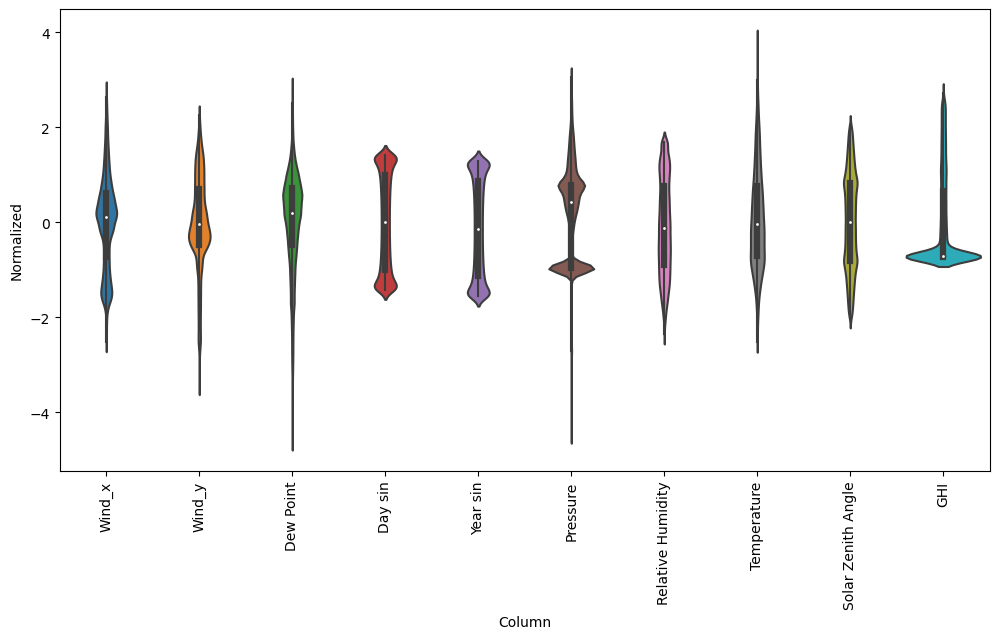

In [138]:
df_std = (df_to_fit[numerical_features] - train_mean[numerical_features]) / train_std[numerical_features]
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[numerical_features].keys(), rotation=90)

In [27]:
num_features = ['Wind_x', 'Wind_y', 'Dew Point', 'Day sin', 'Year sin', 'Pressure', 'Relative Humidity', 'Temperature', 'Solar Zenith Angle']
cloudtypes = to_categorical(df['Cloud Type'])

In [28]:
stacked_data = np.hstack([df[num_features].values])

# Scale
ss = StandardScaler()
stacked_sc = ss.fit_transform(stacked_data)
ss_y = StandardScaler()
stacked_tot = np.hstack([stacked_sc[:,:], cloudtypes[:,:], ss_y.fit_transform(df[['GHI']].values)])

In [29]:
def split_sequences(data_in, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(data_in.shape[0]):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > data_in.shape[0]:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data_in[i:end_ix, :-1], data_in[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 192, 24
# covert into input/output
X, y = split_sequences(stacked_tot, n_steps_in, n_steps_out)
nr_features = X.shape[2]

In [30]:
split_point = 1300 * 48
a = 1
train_X , train_y = X[:split_point, :] , y[:split_point, :]
test_X , test_y = X[split_point:, :] , y[split_point:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((62400, 192, 19), (62400, 24), (25082, 192, 19), (25082, 24))

In [31]:
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(n_steps_in, nr_features)))
lstm_model.add(Dense(n_steps_out))

In [32]:
#optimizer learning rate
opt = Nadam(learning_rate=0.0005)
es = EarlyStopping(patience=5)
lstm_model.compile(loss='mse' , optimizer=opt , metrics=[RSquare()])

In [33]:
history = lstm_model.fit(train_X , train_y, batch_size=1000, epochs=90, verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False, callbacks=[es])

Epoch 1/90
63/63 [==============================] - 15s 207ms/step - loss: 0.9802 - r_square: 0.0300 - val_loss: 0.8223 - val_r_square: 0.1595
Epoch 2/90
63/63 [==============================] - 12s 193ms/step - loss: 0.7200 - r_square: 0.2875 - val_loss: 0.5104 - val_r_square: 0.4783
Epoch 3/90
63/63 [==============================] - 12s 193ms/step - loss: 0.4276 - r_square: 0.5768 - val_loss: 0.2927 - val_r_square: 0.7008
Epoch 4/90
63/63 [==============================] - 12s 193ms/step - loss: 0.2731 - r_square: 0.7297 - val_loss: 0.2099 - val_r_square: 0.7855
Epoch 5/90
63/63 [==============================] - 12s 193ms/step - loss: 0.2102 - r_square: 0.7919 - val_loss: 0.1746 - val_r_square: 0.8215
Epoch 6/90
63/63 [==============================] - 12s 193ms/step - loss: 0.1784 - r_square: 0.8235 - val_loss: 0.1557 - val_r_square: 0.8409
Epoch 7/90
63/63 [==============================] - 12s 194ms/step - loss: 0.1579 - r_square: 0.8437 - val_loss: 0.1424 - val_r_square: 0.8544

In [34]:
preds_train = lstm_model.predict(train_X)
preds_test = lstm_model.predict(test_X)

784/784 [==============================] - 7s 8ms/step


In [35]:
test_y_ghi = ss_y.inverse_transform(test_y)
preds_test_ghi = ss_y.inverse_transform(preds_test)

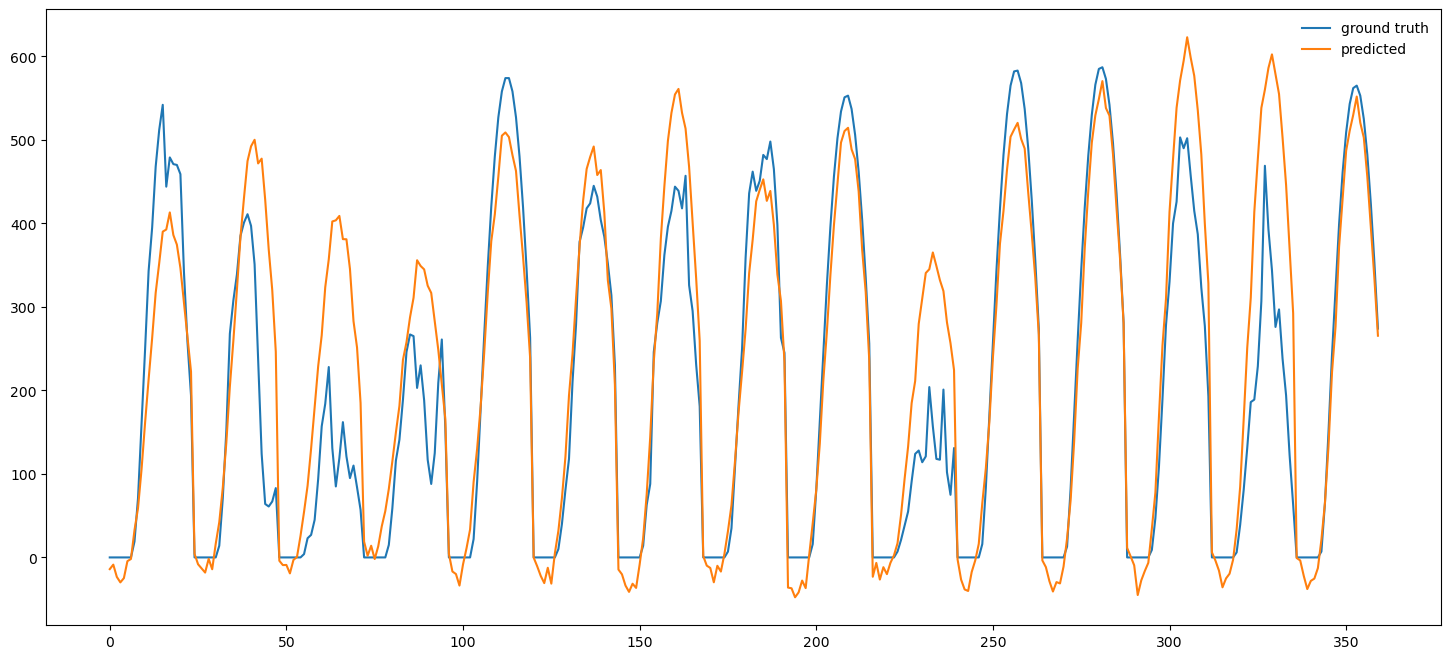

In [42]:
preds_l, test_l = [], []
x = 8
for i in range(130,145):
    test_l += list(test_y_ghi[i*48+x,:])
    preds_l += list(preds_test_ghi[i*48+x,:])
plt.figure(figsize=(18, 8))
plt.plot(test_l, label='ground truth')
plt.plot(preds_l, label='predicted')
plt.legend(frameon=False)